# Decoding analysis
This notebook demonstrates a machine learning approach to analyse the data. The goal is to predict the stimulus from the neural activity. This information based approach is different from the traditional hypothesis testing approach. In the hypothesis testing approach, we test whether the neural activity is significantly different between different two conditions. In the information based approach, we test whether the neural activity contains information about the condition.


If you are interested in reading some neuroscience papers that uses decoding analysis, here are some examples:
- [Decoding Brain Responses to Names and Voices across Different Vigilance States](https://www.mdpi.com/1424-8220/21/10/3393)
- [Resolving human object recognition in space and time](https://www.nature.com/articles/nn.3635)
- [Neural dynamics of phoneme sequences reveal position-invariant code for content and order](https://www.nature.com/articles/s41467-022-34326-1)

More methods oriented papers:
- [Characterizing the dynamics of mental representations: the temporal generalization method](https://www.sciencedirect.com/science/article/abs/pii/S1364661314000199)
- [Information-based functional brain mapping](https://www.pnas.org/doi/10.1073/pnas.0600244103) (mainly for fMRI, but the idea is the same)
- [Deconstructing multivariate decoding for the study of brain function](https://pubmed.ncbi.nlm.nih.gov/28782682/)

and at last, a technical review paper discussing interpretations both of activation and information based analysis. More specifically they argue that most analysis focus on the information we can measure as experimenters (experimenter-as-receiver), rather than on how the rest of the brain interpret those activations (cortex-as-receiver). Can be helpful in terms of interpreting and discussing results:
- [Does neuroimaging measure information in the brain?](https://pubmed.ncbi.nlm.nih.gov/26833316/)

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Loading the data

In [7]:
# load data from one participant
data_path = Path("/work/EEG_lab/example_data_stats")
epochs = mne.read_epochs(data_path / "Group1-epo.fif", preload=True)

# only keep eeg channels
epochs = epochs.pick(["eeg"])

Reading /work/EEG_lab/example_data_stats/Group1-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


## Decoding using data from a single subject
This notebook focuses on within-subject decoding. That is we train a model on data from one subject and test it on the same subject. However, we should always use a separate dataset for training and testing to avoid overfitting. This means that we cannot train and test the model on data from the same trials from our subject. Therefore, we use k-fold cross-validation. If you are not familiar with cross-validation, you can read more about it [here](https://spotintelligence.com/2023/07/29/k-fold-cross-validation/). 


Some studies also conduct cross-subject decoding, where the model is trained on one subject and tested on another subject. This is useful for testing whether the model can generalize to new subjects - however this is not introduced in this notebook, but should be relatively easy to implement relying on the code in this notebook. 

For the purpose of this tutorial, we will see if we can decode whether the subject is presented with a word or an image (i.e., smiley). Therefore, we begin by extracting the data from the two conditions.

In [8]:
# get all the word from the first participant
words = epochs["Word"].get_data()

# get all the image from the first participant (smiley face)
images = epochs["Image"].get_data()

Now we need to make a variable that contains the labels for the two conditions *y*. We will use 0 for the word condition and 1 for the image condition. Furthermore we concatenate the data from the two conditions into one variable *X*.

In [9]:
y = [0] * len(words) + [1] * len(images)
y = np.array(y)

# concatenate the data along the trials axis
X = np.concatenate([words, images], axis=0)

print(X.shape)
print(y.shape)

(120, 28, 175)
(120,)


Now that we have prepared the data and the labels, we can start the decoding analysis. We will use the `scikit-learn` library for this purpose. This library contains a lot of useful tools for machine learning.

We will be using a linear discriminant analysis (LDA) classifier. LDA is a simple and fast classifier that is often used for decoding analysis. If you are not familiar with LDA, you can read more about it [here](https://scikit-learn.org/stable/modules/lda_qda.html).

First we will be using a simple decoding analysis, where we train the model on data from a single time point. Then we will use a more advanced decoding analysis, where we test the decoding accuracy at all time points. Finally, we will use a temporal generalization analysis, where we train the model on data from one time point and test it on all time points.

### Decoding at one time point
Lets begin by focusing on one time point. We will use the first time point, but you can change this to any time point you want.

In [10]:
# get data from timesample 1
X_t1 = X[:, :, 1]

print(X_t1.shape)

(120, 28)


As we do not want to train and test our model on the same data, we will split the data into some cross-validation folds. We will use 5 folds, so we will train the model on 4/5 of the data and test it on the remaining 1/5 of the data. We will repeat this 5 times, so that we have tested the model on all the data. For the purpose of splitting the data, I have defined a function below. 

In [11]:
def cross_val_splits(X, y, n_splits=5, shuffle=True, balance=True, stratify=True):
    """
    Function to create cross validation splits
    
    Parameters
    ----------
    X : np.ndarray
        The data to split of shape (n_trials, n_channels) or (n_trials, n_channels, n_timesamples)

    y : np.ndarray
        The labels of shape (n_trials,) with 0 indicating the first class and 1 the second class

    n_splits : int
        The number of splits to create
    
    shuffle : bool
        Whether to shuffle the data before splitting
    
    balance : bool
        Whether to balance the data before splitting (i.e. have the same number of trials for each class in each split)

    stratify : bool
        Whether to stratify the data before splitting (i.e. have the same class distribution in each split)
    
    Returns
    -------
    Xs : list
        A list of length n_splits containing the data splits
    
    ys : list
        A list of length n_splits containing the label splits
    """

    if balance:
        # Get the indices of the trials for each class
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]

        # Get the minimum number of trials for each class
        min_trials = min(len(idx_0), len(idx_1))

        # Randomly sample the indices and concatenate them
        idx = np.concatenate([np.random.choice(idx_0, min_trials, replace=False),
                              np.random.choice(idx_1, min_trials, replace=False)])

        # Get the data and labels for the balanced data
        X, y = X[idx], y[idx]

    idx = np.arange(len(X))

    if shuffle:
        np.random.shuffle(idx)

    if stratify:
        # Get the indices of the trials for each class
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]

        # Concatenate the indices for each class
        idx_splits = [np.concatenate([np.array_split(idx_class, n_splits)[i] for idx_class in [idx_0, idx_1]]) for i in range(n_splits)]

        # Randomly shuffle the indices for each split
        idx_splits = [np.random.permutation(split) for split in idx_splits]

        # Concatenate the indices
        idx = np.concatenate(idx_splits)

    # split the data into n_splits
    splits = np.array_split(idx, n_splits)

    Xs = [X[split] for split in splits]
    ys = [y[split] for split in splits]

    return Xs, ys


In [12]:
n_splits = 5 # number of splits to create (5 is arbitrary, you can change this. The more splits, the more accurate the estimate of the accuracy but the longer it takes to run)

# create cross validation splits
Xs, ys = cross_val_splits(
    X_t1, 
    np.array(y), 
    n_splits = n_splits,
    shuffle = True,
    balance = True,
    stratify = True
)

# make the classifier object
clf = lda()

accuracies = np.array([])

# loop over the splits
for i in range(n_splits):
    # get the train and test data
    X_train = np.concatenate([Xs[j] for j in range(n_splits) if j != i], axis=0)
    X_test = Xs[i]

    y_train = np.concatenate([ys[j] for j in range(n_splits) if j != i], axis=0)
    y_test = ys[i]

    # fit the classifier
    clf.fit(X_train, y_train)

    # get the accuracy
    accuracy = clf.score(X_test, y_test)

    # append the accuracy to the list
    accuracies = np.append(accuracies, accuracy)

print(f"accuracies for each split: {accuracies}")
print(f"mean accuracy: {np.mean(accuracies)}")


accuracies for each split: [0.45833333 0.75       0.70833333 0.5        0.375     ]
mean accuracy: 0.5583333333333333


### Decoding at all time points
Now we have tested the ability to decode the condition at one time point. However, it might be interesting to see how the decoding accuracy changes over the duration of the trial. We can do this by looping through all the time points and decoding the condition at each time point. We will store the decoding accuracy for each time point in a variable *accuracy*.

This allows us to plot the decoding accuracy as a function of time, which informs when the condition can be decoded from the neural activity.

In [13]:
# create cross validation splits
Xs, ys = cross_val_splits(
    X, 
    np.array(y), 
    n_splits = n_splits,
    shuffle = True,
    balance = True,
    stratify = True
)

In [14]:
# make a shape (n_splits, n_timesamples) array to store the accuracies
accuracies = np.zeros((n_splits, X.shape[2]))

# make a shape to store the beta coefficients (n_splits, n_channels, n_timesamples)
betas = np.zeros((n_splits, X.shape[1], X.shape[2]))

# prepare the scaler for scaling the data
scaler = StandardScaler()

# loop over the splits
for i in range(n_splits):
    # get the train and test data
    X_train = np.concatenate([Xs[j] for j in range(n_splits) if j != i], axis=0)
    X_test = Xs[i]

    y_train = np.concatenate([ys[j] for j in range(n_splits) if j != i], axis=0)
    y_test = ys[i]

    # loop over the timesamples
    for t in range(X_train.shape[2]):
        
        # scale the data (notice that we fit the scaler to the training data and not the test data)
        X_train_scaled = scaler.fit_transform(X_train[:, :, t])
        X_test_scaled = scaler.transform(X_test[:, :, t])

        # fit the classifier
        clf.fit(X_train_scaled, y_train)

        # get the accuracy
        accuracy = clf.score(X_test_scaled, y_test)

        # save the beta coefficients
        betas[i, :, t] = clf.coef_

        # save the accuracy
        accuracies[i, t] = accuracy

print(f"mean accuracy: {np.mean(accuracies)}")

mean accuracy: 0.572


#### Plot the decoding accuracy over time
Now we can plot the decoding accuracy as a function of time.

Text(0, 0.5, 'Accuracy')

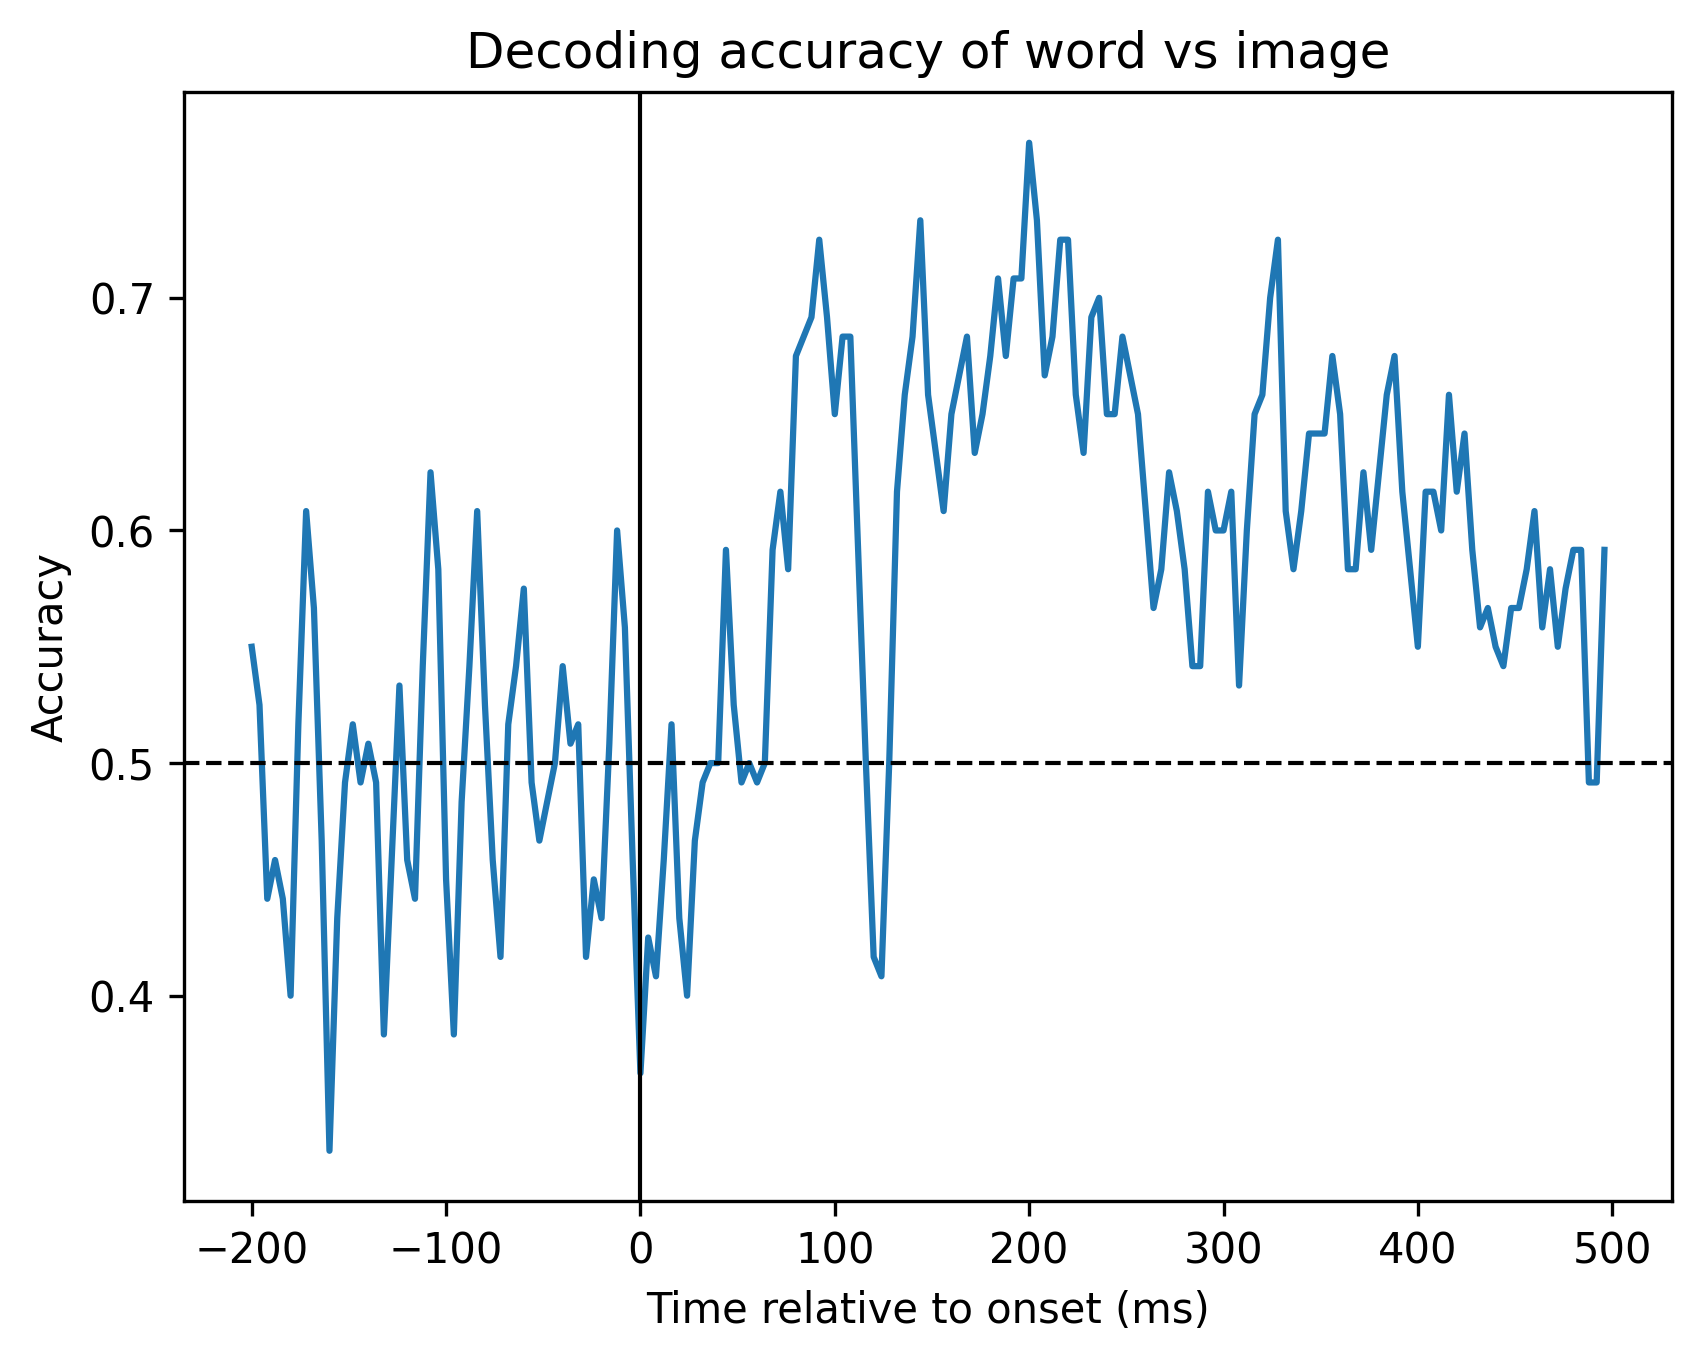

In [15]:
# plot the accuracy over time
fig, ax = plt.subplots(dpi = 300)

# take the mean over the splits
accuracies_avg = np.mean(accuracies, axis=0)

# times instead of timesamples (downsampled to 250 hz in preprocessing and epoched from -200 ms to 500 ms)
times = np.arange(-200, 500, 1000/250)

# plot the accuracies
ax.plot(times, accuracies_avg)

# plot a horizontal line at chance level (0.5) BEAWARE THAT WE HAVE FEW TRIALS, SO CHANCE LEVEL CAN EXEEED 0.5 BY CHANCE
ax.axhline(0.5, color="black", linestyle="--", linewidth=1)

# plot a vertical line at 0 ms indicating onset
ax.axvline(0, color="black", linestyle="solid", linewidth=1)

ax.set_title("Decoding accuracy of word vs image")

ax.set_xlabel("Time relative to onset (ms)")
ax.set_ylabel("Accuracy")

#### Plot of beta (weights) over time
We can also plot the weights of the model as a function of time. This can give us an idea of which electrodes are important for the decoding.

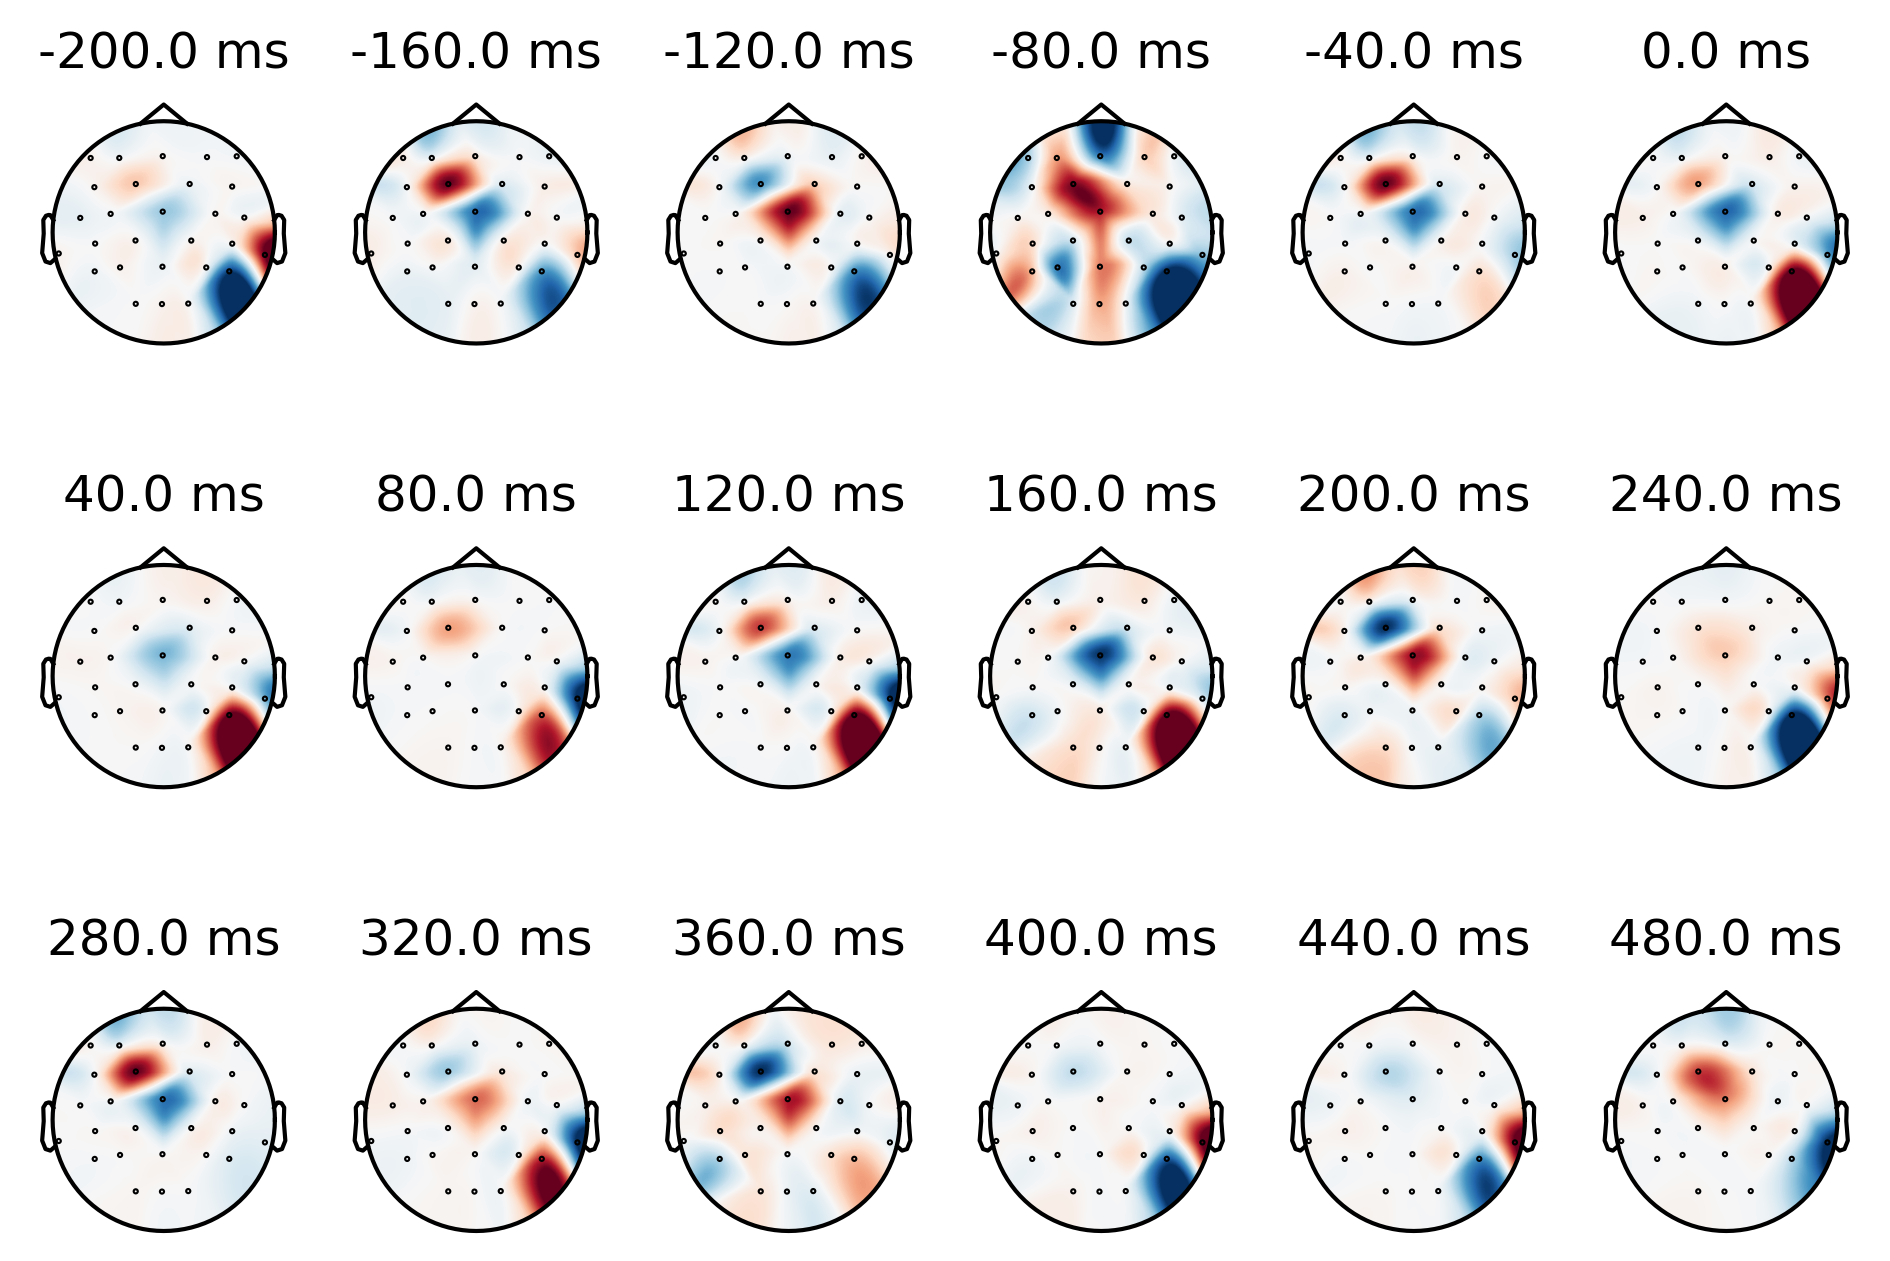

In [16]:
# choosing some times to plot
times_to_plot = np.arange(0, len(times), 10)

fig, axes = plt.subplots(3, len(times_to_plot)//3,  dpi=300, sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    mne.viz.plot_topomap(betas[:, :, times_to_plot[i]].mean(axis=0), epochs.info, axes=ax, show=False, contours=0)
    ax.set_title(f"{times[times_to_plot[i]]} ms")

# plot 

fig.tight_layout()

### Temporal generalisation
So far we have only looked at decoding the condition at each time point. However, we can also use the model trained at one time point to predict the condition at another time point. This is called temporal generalisation. We can do this by looping through all the time points and training the model at one time point and testing it at all other time points.

In [17]:
# make a shape (n_splits, n_timesamples, n_timesamples) array to store the accuracies
accuracies = np.zeros((n_splits, X.shape[2], X.shape[2]))

# prepare the scaler for scaling the data
scaler = StandardScaler()

# loop over the splits
for i in range(n_splits):
    # get the train and test data
    X_train = np.concatenate([Xs[j] for j in range(n_splits) if j != i], axis=0)
    X_test = Xs[i]

    y_train = np.concatenate([ys[j] for j in range(n_splits) if j != i], axis=0)
    y_test = ys[i]

    # loop over the timesamples for training
    for t in range(X_train.shape[2]):
        print(f"split {i+1}/{n_splits}, time {t+1}/{X_train.shape[2]}")
        
        # scale the data (notice that we fit the scaler to the training data and not the test data)
        X_train_scaled = scaler.fit_transform(X_train[:, :, t])

        # fit the classifier
        clf.fit(X_train_scaled, y_train)

        # loop over the timesamples for testing
        for tt in range(X_test.shape[2]):
            X_test_scaled = scaler.transform(X_test[:, :, tt])


            # get the accuracy
            accuracy = clf.score(X_test_scaled, y_test)

            # save the accuracy
            accuracies[i, t, tt] = accuracy

print(f"mean accuracy: {np.mean(accuracies)}")

split 1/5, time 1/175
split 1/5, time 2/175
split 1/5, time 3/175
split 1/5, time 4/175
split 1/5, time 5/175
split 1/5, time 6/175
split 1/5, time 7/175
split 1/5, time 8/175
split 1/5, time 9/175
split 1/5, time 10/175
split 1/5, time 11/175
split 1/5, time 12/175
split 1/5, time 13/175
split 1/5, time 14/175
split 1/5, time 15/175
split 1/5, time 16/175
split 1/5, time 17/175
split 1/5, time 18/175
split 1/5, time 19/175
split 1/5, time 20/175
split 1/5, time 21/175
split 1/5, time 22/175
split 1/5, time 23/175
split 1/5, time 24/175
split 1/5, time 25/175
split 1/5, time 26/175
split 1/5, time 27/175
split 1/5, time 28/175
split 1/5, time 29/175
split 1/5, time 30/175
split 1/5, time 31/175
split 1/5, time 32/175
split 1/5, time 33/175
split 1/5, time 34/175
split 1/5, time 35/175
split 1/5, time 36/175
split 1/5, time 37/175
split 1/5, time 38/175
split 1/5, time 39/175
split 1/5, time 40/175
split 1/5, time 41/175
split 1/5, time 42/175
split 1/5, time 43/175
split 1/5, time 44/1

#### Plot the temporal generalisation matrix

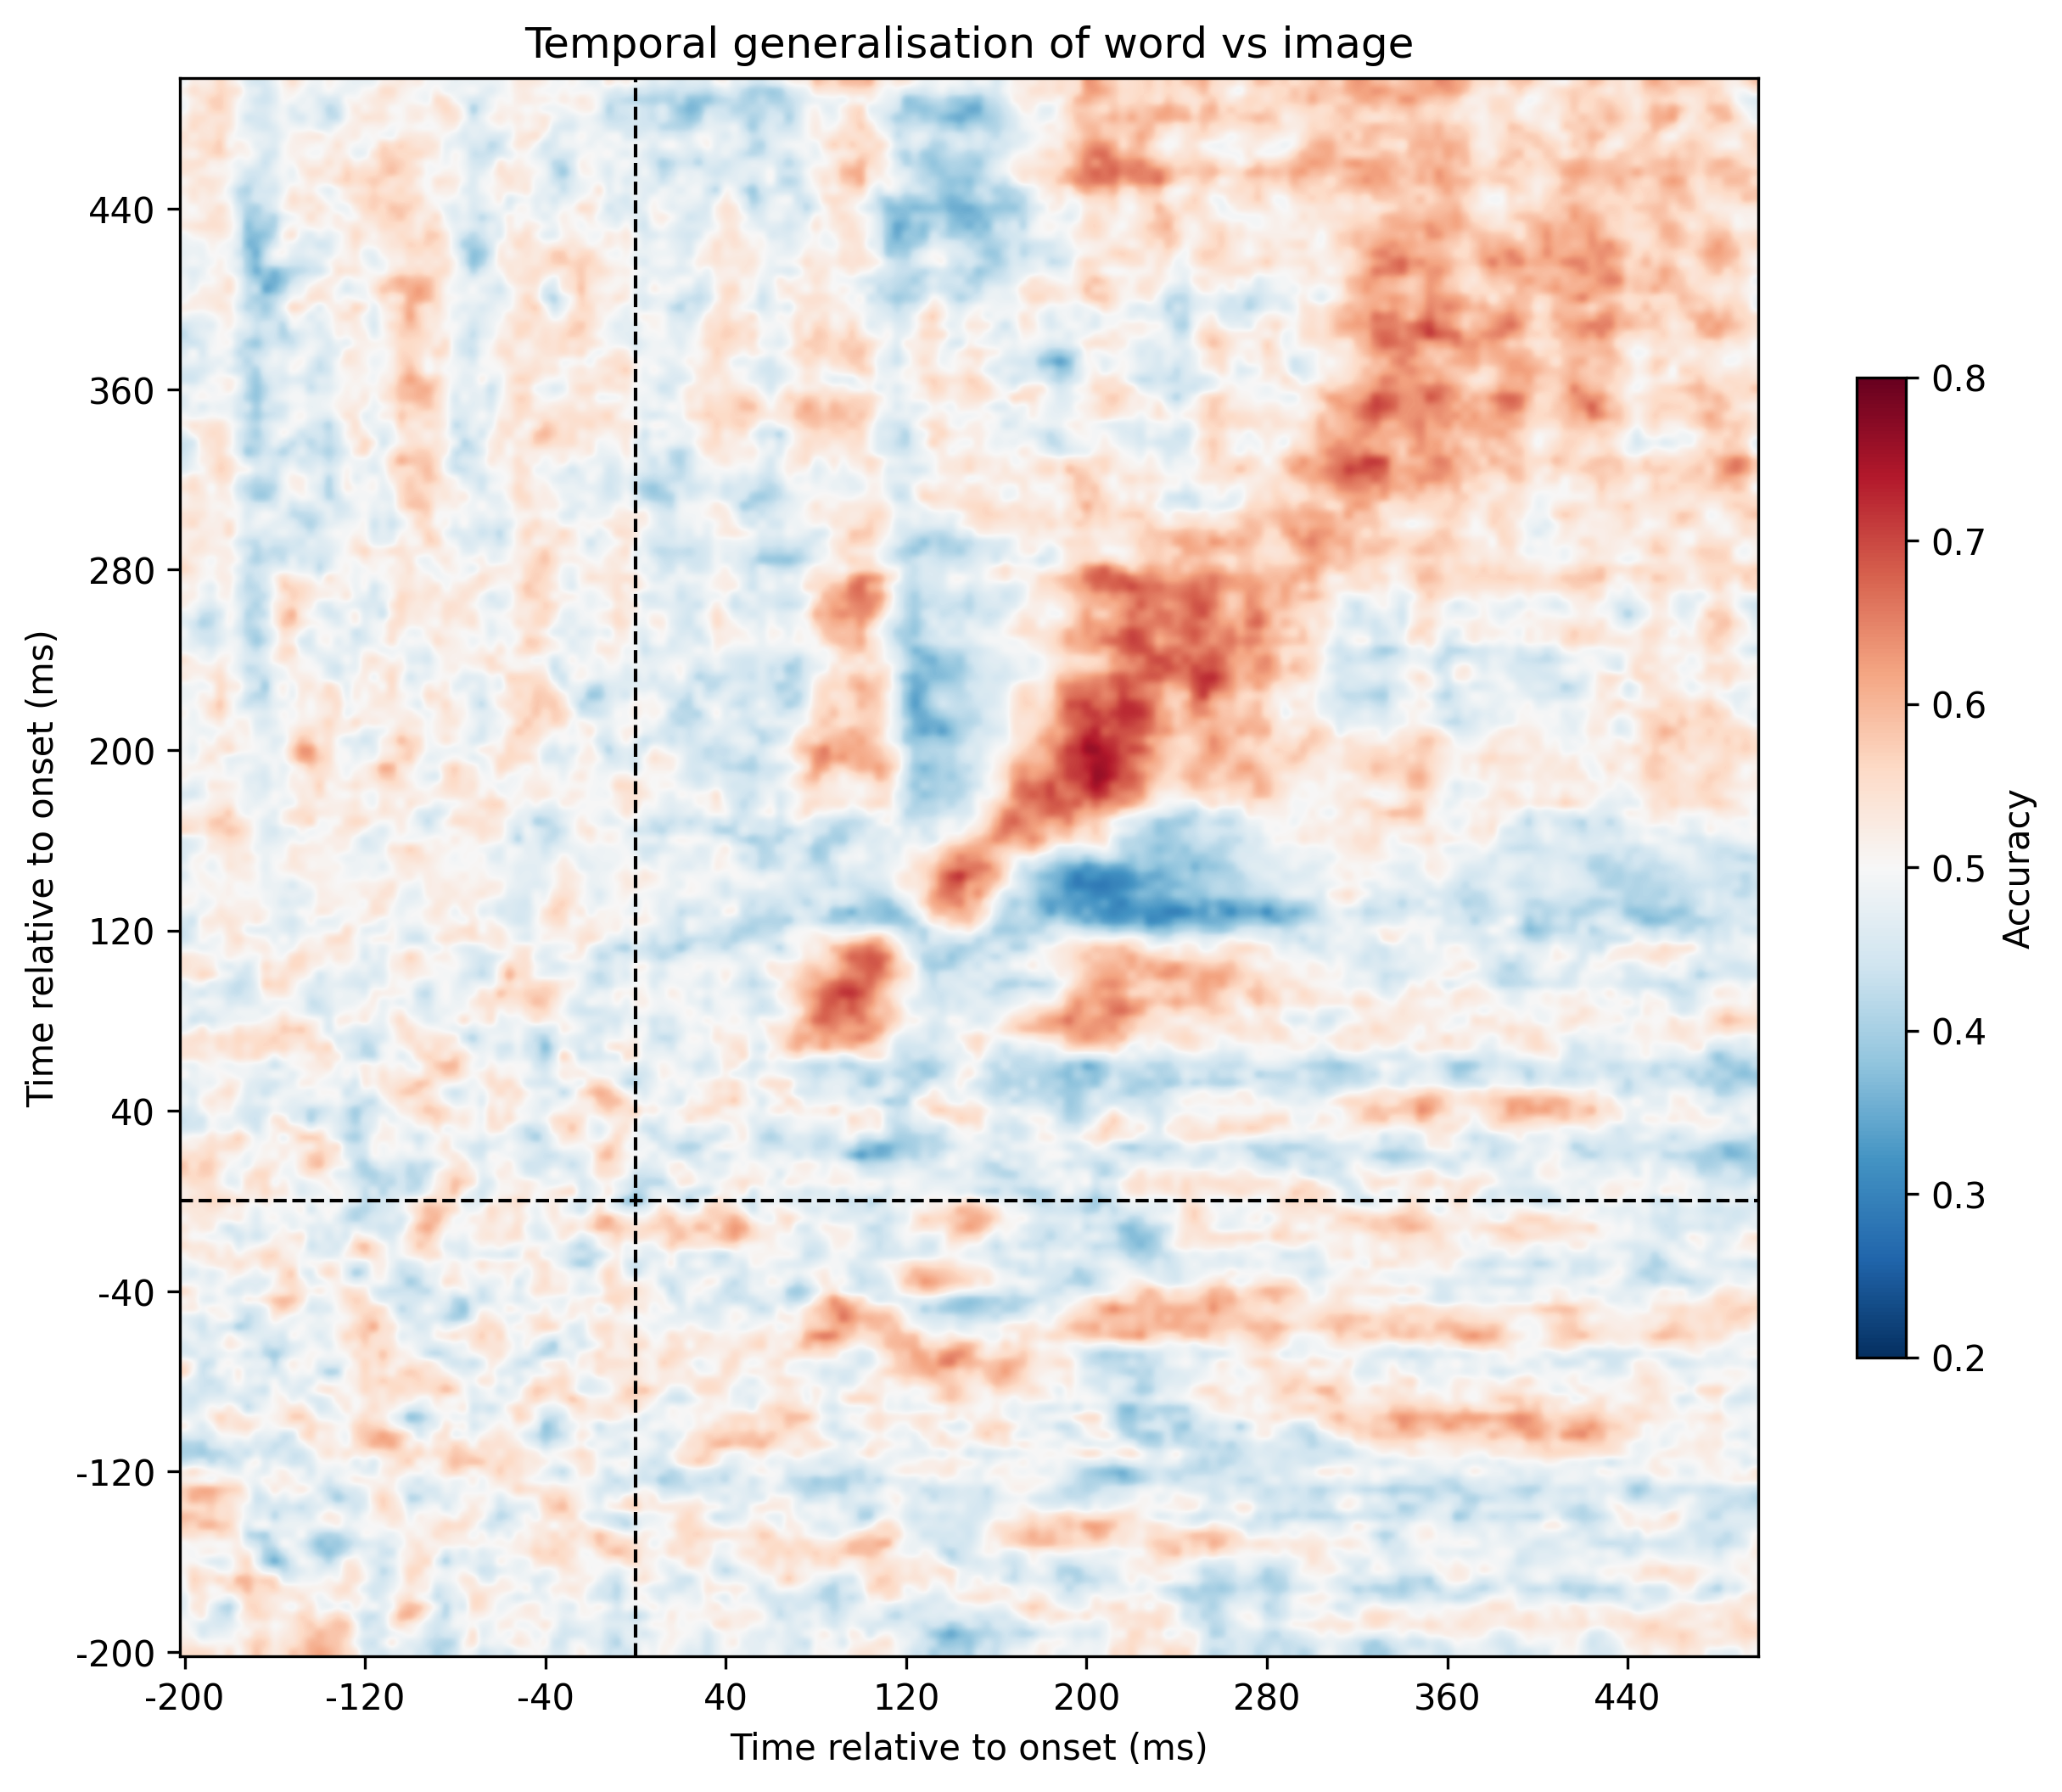

In [18]:
# take the mean over the splits
accuracies_avg = np.mean(accuracies, axis=0)

fig, ax = plt.subplots(1, figsize=(10, 10), dpi=300)

# plot the accuracies
im = ax.imshow(accuracies_avg, vmin=0.2, vmax=0.8, origin="lower", cmap="RdBu_r", interpolation="gaussian")

# times instead of timesamples (downsampled to 250 hz in preprocessing and epoched from -200 ms to 500 ms) on the x and y axis
times = np.arange(-200, 500, 1000/250)
times = times.astype(int)

# only plot every 20th timepoint
ax.set_xticks(np.arange(len(times))[::20])
ax.set_xticklabels(times[::20])
ax.set_yticks(np.arange(len(times))[::20])
ax.set_yticklabels(times[::20])

# label the axes
ax.set_xlabel("Time relative to onset (ms)")
ax.set_ylabel("Time relative to onset (ms)")

ax.set_title("Temporal generalisation of word vs image")

# add a colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("Accuracy")

# plot lines at 0 indicating onset
ax.axhline(50, color="black", linestyle="--", linewidth=1)
ax.axvline(50, color="black", linestyle="--", linewidth=1)